In [1]:
#import symlens as s
#from pixell import enmap, utils as putils, powspec
#import os,sys
#from scipy.interpolate import interp1d
import numpy as np
#import pytest
import matplotlib.pyplot as plt
import camb
from multiprocessing import Pool
from functools import partial
from tqdm import tqdm



In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='serif')

In [3]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(12000, lens_potential_accuracy=2);
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

ls = np.arange(powers['unlensed_scalar'].shape[0])
## CAMB outputs l(l+1)/(2pi) * C_l by default, need to rescale
ell_fac = ls*(ls+1.)/(2*np.pi)
ctt_unlensed = (powers['unlensed_scalar'][:,0]/ell_fac)
## CAMB outputs l(l+1)/(2pi) * C_l^{dd} by default, need to rescale to C_l^{phiphi}
ctt_lensed = (powers['total'][:,0]/ell_fac)
ell_fac_phi = (ls*(ls+1.)*ls*(ls+1.))/(2*np.pi)
cphiphi = (powers['lens_potential'][:,0]/ell_fac_phi)



/users/jrmeyers/.conda/envs/idp_cobaya/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/users/jrmeyers/.conda/envs/idp_cobaya/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/users/jrmeyers/.conda/envs/idp_cobaya/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [4]:
# Extend spectra to higher ell
nPad = 20000
ctt_unlensed = np.pad(ctt_unlensed,(0,nPad), 'constant', constant_values = 0.)
cphiphi = np.pad(cphiphi,(0,nPad), 'constant', constant_values = 0.)
ctt_lensed = np.pad(ctt_lensed,(0,nPad), 'constant', constant_values = 0.)
ls = np.arange(ctt_unlensed.shape[0])

# Noise spectrum CMB-S4
Delta_T = 1.  # In muK-arcmin
theta_fwhm = 1.   # in arcmin
ntt_CMBS4 = (Delta_T*np.pi/180./60.)**2. * np.exp((theta_fwhm*np.pi/180./60.)**2.*ls**2./ (8.*np.log(2))) 

# Noise spectrum
Delta_T = 27.  # In muK-arcmin
theta_fwhm = 7.   # in arcmin
ntt_planck = (Delta_T*np.pi/180./60.)**2. * np.exp((theta_fwhm*np.pi/180./60.)**2.*ls**2./ (8.*np.log(2))) 

ctt_total_CMBS4 = ctt_lensed + ntt_CMBS4
ctt_total_planck = ctt_lensed + ntt_planck

ctt_unlensed[0] = 0.
ctt_total_CMBS4[0] = 1.e10
ctt_total_planck[0] = 1.e10
cphiphi[0]=0.
ctt_lensed[0] = 0.

In [5]:
%load_ext cython

In [6]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

cimport cython
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def Psi_and_A_cy(int L, double[:] ClTTunlensed, double[:] ClTTtotal, double[:] Clphiphi, \
                 int l1min, int l1max, int l2min, int l2max, int dl1, int dl2):
    
    cdef int l1x
    cdef int l1y
    cdef int l2x
    cdef int l2y
    cdef int nl1
    cdef int l1max_round
    nl1 = l1max/dl1
    l1max_round = nl1*dl1
    cdef int nl2
    cdef int l2max_round
    nl2 = l2max/dl2
    l2max_round = nl2*dl2
    #print(lmax_round)
    
    cdef int l1dotl1minusL
    cdef int l2dotl2minusl1
    cdef int Lminusl2dotl1minusl2
    cdef int l2dotl2minusL
    
    cdef int modl1
    cdef int modLminusl1
    cdef int modl2
    cdef int modLminusl2
    cdef int modl1minusl2
    
    cdef double integrand = 0.
    cdef double integral = 0.
    cdef double AL = 0.
    
    #for l1x from -lmax <= l1x < lmax by dl:
    for l1x in prange(-l1max_round, l1max_round+1, dl1, nogil = True):
        for l1y from -l1max_round <= l1y < l1max_round+1 by dl1:
            modl1 = <int> ((l1x*l1x+l1y*l1y)**(0.5))
            modLminusl1 = <int> (((L-l1x)*(L-l1x) + l1y*l1y)**(0.5))
            if (modl1 < l1min or modl1 > l1max):
                integral += 0.
            elif (modLminusl1 < l1min or modLminusl1 > l1max):
                integral += 0.
            else:
                l1dotl1minusL = l1x*(l1x-L) + l1y*(l1y)
                for l2x from -l2max_round <= l2x < l2max_round+1 by dl2:
                    for l2y from -l2max_round <= l2y < l2max_round+1 by dl2:
                        modl2 = <int> ((l2x*l2x+l2y*l2y)**(0.5))
                        modLminusl2 = <int> (((L-l2x)*(L-l2x) + l2y*l2y)**(0.5))
                        if (modl2 < l2min or modl2 > l2max):
                            integral += 0.
                        elif (modLminusl2 < l2min or modLminusl2 > l2max):
                            integral += 0.
                        else:
                            l2dotl2minusl1 = l2x*(l2x-l1x) + l2y*(l2y-l1y)
                            Lminusl2dotl1minusl2 = (L-l2x)*(l1x-l2x) + (-l2y)*(l1y-l2y)
                            l2dotl2minusL = l2x*(l2x-L) + l2y*(l2y)
                            modl1minusl2 = <int> (((l1x-l2x)*(l1x-l2x) + (l1y-l2y)*(l1y-l2y))**(0.5))

                            integrand = 2. \
                                * 1./(ClTTtotal[modl1] * ClTTtotal[modLminusl1]) \
                                * (ClTTunlensed[modl2]*ClTTunlensed[modl2]/ClTTtotal[modl2]) \
                                * (ClTTunlensed[modLminusl2]*ClTTunlensed[modLminusl2]/ClTTtotal[modLminusl2]) \
                                * l1dotl1minusL * l2dotl2minusl1 * Lminusl2dotl1minusl2 * l2dotl2minusL
                            
                            AL += integrand
                            integral += integrand*Clphiphi[modl1minusl2]
    
    integral *= dl1*dl1*dl2*dl2
    AL *= dl1*dl1*dl2*dl2
    AL = 1./AL
    # Results need to be scaled by (2\pi)^4
    
    return integral, AL
                    

In [7]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

cimport cython
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def dPsi_dCphi_cy(int L, int ell, double[:] ClTTunlensed, double[:] ClTTtotal, int l1min, int l1max, int l2min, int l2max, int dl1, int dl2):
    
    cdef int l1x
    cdef int l1y
    cdef int l2x
    cdef int l2y
    cdef int nl1
    cdef int l1max_round
    nl1 = l1max/dl1
    l1max_round = nl1*dl1
    cdef int nl2
    cdef int l2max_round
    nl2 = l2max/dl2
    l2max_round = nl2*dl2
    #print(lmax_round)
    
    cdef int l1dotl1minusL
    cdef int l2dotl2minusl1
    cdef int Lminusl2dotl1minusl2
    cdef int l2dotl2minusL

    cdef int radicand
    cdef int sqrt_sign
    
    cdef int modl1
    cdef int modLminusl1
    cdef int modl2
    cdef int modLminusl2
    
    cdef double integral = 0
    
    #for l1x from -lmax <= l1x < lmax by dl:
    for l1x in prange(-l1max_round, l1max_round+1, dl1, nogil = True):
        for l1y from -l1max_round <= l1y < l1max_round+1 by dl1:
            modl1 = <int> ((l1x*l1x+l1y*l1y)**(0.5))
            modLminusl1 = <int> (((L-l1x)*(L-l1x) + l1y*l1y)**(0.5))
            if (modl1 < l1min or modl1 > l1max):
                integral += 0.
            elif (modLminusl1 < l1min or modLminusl1 > l1max):
                integral += 0.
            else:
                l1dotl1minusL = l1x*(l1x-L) + l1y*(l1y)
                for l2x from -l2max_round <= l2x < l2max_round+1 by dl2:
                    radicand = ell*ell-(l1x-l2x)*(l1x-l2x)
                    if radicand < 0:
                        integral += 0.
                    else:
                        for sqrt_sign from -1 <= sqrt_sign < 2 by 2:
                            l2y = <int> (l1y + sqrt_sign*(radicand**(0.5)))
                            modl2 = <int> ((l2x*l2x+l2y*l2y)**(0.5))
                            modLminusl2 = <int> (((L-l2x)*(L-l2x) + l2y*l2y)**(0.5))
                            if (modl2 < l2min or modl2 > l2max):
                                integral += 0.
                            elif (modLminusl2 < l2min or modLminusl2 > l2max):
                                integral += 0.
                            else:
                                l2dotl2minusl1 = l2x*(l2x-l1x) + l2y*(l2y-l1y)
                                Lminusl2dotl1minusl2 = (L-l2x)*(l1x-l2x) + (-l2y)*(l1y-l2y)
                                l2dotl2minusL = l2x*(l2x-L) + l2y*(l2y)

                                integral += 2. \
                                    * 1./(ClTTtotal[modl1] * ClTTtotal[modLminusl1]) \
                                    * (ClTTunlensed[modl2]*ClTTunlensed[modl2]/ClTTtotal[modl2]) \
                                    * (ClTTunlensed[modLminusl2]*ClTTunlensed[modLminusl2]/ClTTtotal[modLminusl2]) \
                                    * l1dotl1minusL * l2dotl2minusl1 * Lminusl2dotl1minusl2 * l2dotl2minusL
    
    integral *= dl1*dl1*dl2
    # Result needs to be divided by (2\pi)^4
    
    return integral
                    


In [8]:
%%time

###### Testing ########

#dPsi_dCphi_cy(int L, int ell, double[:] ClTTunlensed, double[:] ClTTtotal, int l1min, int l1max, int l2min, int l2max, int dl1, int dl2)
dPsi_dCphi_cy(50, 6000, ctt_unlensed, ctt_total_planck, 6000, 8000, 30, 3000, 100, 100)/((2.*np.pi)**4)

CPU times: user 186 ms, sys: 0 ns, total: 186 ms
Wall time: 23.9 ms


144827631101718.5

In [9]:
%%time

##### Testing ##########

#def Psi_and_A_cy(int L, double[:] ClTTunlensed, double[:] ClTTtotal, double[:] Clphiphi, \
#                 int l1min, int l1max, int l2min, int l2max, int dl1, int dl2)

Psi, A = Psi_and_A_cy(50, ctt_unlensed, ctt_total_planck, cphiphi, 6000, 8000, 30, 3000, 100, 100)

CPU times: user 7.57 s, sys: 108 ms, total: 7.67 s
Wall time: 1.05 s


In [10]:
## Setup ell ranges here

Lmax = 3000
Lmin = 30
dL = 100
Lv = np.arange(Lmin, Lmax, dL)

dell = 100
ellmax = 10000
ellmin = 3000
ellv = np.arange(ellmin, ellmax, dell)

AL = np.zeros(np.shape(Lv)[0])
Psi = np.zeros(np.shape(Lv)[0])
dPsi_dCphi = np.zeros((np.shape(Lv)[0],np.shape(ellv)[0]))

l1min = 6000
l1max = 6500
dl1 = 100
l2min = 30
l2max = 2000
dl2 = 100

pbar = tqdm(total=len(Lv))

for iL, LL in enumerate(Lv):
    Psi[iL], AL[iL] = Psi_and_A_cy(LL, ctt_unlensed, ctt_total_CMBS4, cphiphi, l1min, l1max, l2min, l2max, dl1, dl2)
    AL[iL] *= ((2.*np.pi)**4)
    Psi[iL] *= AL[iL]/((2.*np.pi)**4)
    for iell, ell in enumerate(ellv):
        dPsi_dCphi[iL,iell] = dPsi_dCphi_cy(LL, ell, ctt_unlensed, ctt_total_CMBS4, l1min, l1max, l2min, l2max, dl1, dl2) \
                                * AL[iL]/((2.*np.pi)**4)
    pbar.update(1)
    
pbar.close()

100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


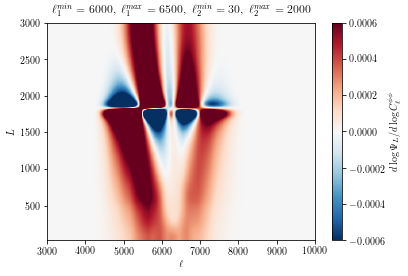

In [11]:
## Plot results here ##

dlogPsi_dlogCphi = (dPsi_dCphi*cphiphi[ellv.astype(int)]).T*1./Psi
#print(np.sum(dlogPsi_dlogCphi*(ellv[1]-ellv[0]), axis = 0))

plt.imshow(dlogPsi_dlogCphi.T, vmin = -0.0006, vmax = 0.0006, extent = (ellmin, ellmax, Lmin, Lmax),
           cmap = 'RdBu_r', aspect = 'auto', interpolation = 'gaussian', origin = 'lower')
plt.xlabel('$\ell$')
plt.ylabel('$L$')
plt.colorbar(label = '$d\log \Psi_L / d\log C_\ell^{\phi\phi}$')
plt.title('$\ell_1^{{min}}={},~\ell_1^{{max}}={},~\ell_2^{{min}}={},~\ell_2^{{max}}={}$'.format(l1min, l1max, l2min, l2max))
plt.savefig('./plots/dlogPsi_dlogCphi_l1min_{}_l1max_{}_l2min_{}_l2max_{}_CMBS4.pdf'.format(l1min, l1max, l2min, l2max), bbox_inches = 'tight')
plt.show()

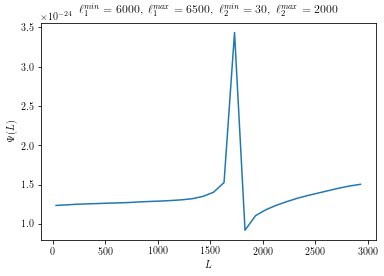

In [12]:
## Plot Psi(L) ##

plt.plot(Lv, Psi)
plt.xlabel('$L$')
plt.ylabel('$\Psi(L)$')
plt.title('$\ell_1^{{min}}={},~\ell_1^{{max}}={},~\ell_2^{{min}}={},~\ell_2^{{max}}={}$'.format(l1min, l1max, l2min, l2max))
plt.savefig('./plots/Psi_l1min_{}_l1max_{}_l2min_{}_l2max_{}_CMBS4.pdf'.format(l1min, l1max, l2min, l2max), bbox_inches = 'tight')
plt.show()

In [ ]:
####  Old stuff starts below ####
####  Includes older, slower versions of integrals
####  Various tests
####  N^(1) bias calculations

In [5]:
def l2integral(l1xv, l1yv, Lv, l2xv, l2yv, ClTTunlensed, ClTTtotal, Clphiphi = None, l2min = 30, l2max = 3000):
    
    #Add axes in order to vectorize integral
    l1x = np.expand_dims(np.expand_dims(np.expand_dims(l1xv,axis=0),axis=-1),axis=-1)
    l1y = np.expand_dims(np.expand_dims(np.expand_dims(l1yv,axis=0),axis=-1),axis=-1)
    L = np.expand_dims(np.expand_dims(np.expand_dims(np.expand_dims(Lv,axis=-1),axis=-1),axis=-1),axis=-1)
    
    ## Testing:
    #print(np.shape(l1x))
    #print(np.shape(l1y))
    #print(np.shape(L))
    
    l2dotl2minusl1 = l2xv*(l2xv-l1x)+l2yv*(l2yv-l1y)
    Lminusl2dotl1minusl2 = (L-l2xv)*(l1x-l2xv) + (-l2yv)*(l1y-l2yv)
    l2dotl2minusL = l2xv*(l2xv-L)+l2yv*l2yv
    modl2 = np.sqrt(l2xv**2+l2yv**2)
    modLminusl2 = np.sqrt((L-l2xv)**2 + l2yv**2)
    modl1minusl2 = np.sqrt((l1x-l2xv)**2 + (l1y-l2yv)**2)
    
    maskl2 = np.ones(np.shape(modl2),dtype = int)
    maskl2[np.where(modl2 < l2min)] = 0
    maskl2[np.where(modl2 > l2max)] = 0

    maskLminusl2 = np.ones(np.shape(modLminusl2),dtype = int)
    maskLminusl2[np.where(modLminusl2 < l2min)] = 0
    maskLminusl2[np.where(modLminusl2 > l2max)] = 0
    
    hfilter = maskl2*ClTTunlensed[np.rint(modl2).astype(int)]/ClTTtotal[np.rint(modl2).astype(int)] \
            * maskLminusl2*ClTTunlensed[np.rint(modLminusl2).astype(int)]/ClTTtotal[np.rint(modLminusl2).astype(int)]
    
    integrand = l2dotl2minusl1*Lminusl2dotl1minusl2*l2dotl2minusL \
                * 2. * hfilter * ClTTunlensed[np.rint(modl2).astype(int)] * ClTTunlensed[np.rint(modLminusl2).astype(int)]
    if Clphiphi is not None:
        integrand *= Clphiphi[np.rint(modl1minusl2).astype(int)]
    
    deltal2x = l2xv[0,1]-l2xv[0,0]
    deltal2y = l2yv[1,0]-l2yv[0,0]
    
    integrand*= deltal2x*deltal2y/((2*np.pi)**2)
    
    ## Testing:
    #print(np.shape(integrand))
    
    return np.sum(integrand, axis=(-2,-1))

def l1integral(l1xv, l1yv, Lv, l2xv, l2yv, ClTTunlensed, ClTTtotal,
               Clphiphi = None, l1min = 6000, l1max = 8000, l2min = 30, l2max = 3000, 
               ell = None, dPsi_dCphi = False):

    #Add axes in order to vectorize integral
    L = np.expand_dims(np.expand_dims(Lv,axis=-1),axis=-1)
    
    ## Testing:
    #print(np.shape(l1x))
    #print(np.shape(l1y))
    #print(np.shape(L))
    
    l1dotl1minusL = l1xv*(l1xv-L)+l1yv*l1yv
    modl1 = np.sqrt(l1xv**2+l1yv**2)
    modLminusl1 = np.sqrt((L-l1xv)**2 + l1yv**2)
    
    maskl1 = np.ones(np.shape(modl1),dtype = int)
    maskl1[np.where(modl1 < l1min)] = 0
    maskl1[np.where(modl1 > l1max)] = 0

    maskLminusl1 = np.ones(np.shape(modLminusl1),dtype = int)
    maskLminusl1[np.where(modLminusl1 < l1min)] = 0
    maskLminusl1[np.where(modLminusl1 > l1max)] = 0
    
    gfilter = maskl1*1./ClTTtotal[np.rint(modl1).astype(int)] \
            * maskLminusl1*1./ClTTtotal[np.rint(modLminusl1).astype(int)]
    
    integrand = l1dotl1minusL * gfilter 
    
    if dPsi_dCphi:
        integrand *= l2integral_dPsi_dCphi(
                   l1xv = l1xv, 
                   l1yv = l1yv, 
                   Lv = Lv, 
                   l2xv = l2xv,  
                   ClTTunlensed = ClTTunlensed, 
                   ClTTtotal = ClTTtotal, 
                   l2min = l2min, 
                   l2max = l2max,
                   ell = ell)
    else:
        integrand *= l2integral(l1xv = l1xv, 
                       l1yv = l1yv, 
                       Lv = Lv, 
                       l2xv = l2xv, 
                       l2yv = l2yv, 
                       ClTTunlensed = ClTTunlensed, 
                       ClTTtotal = ClTTtotal, 
                       Clphiphi = Clphiphi, 
                       l2min = l2min, 
                       l2max = l2max)
   
    deltal1x = l1xv[0,1]-l1xv[0,0]
    deltal1y = l1yv[1,0]-l1yv[0,0]
    
    integrand*= deltal1x*deltal1y/((2*np.pi)**2)
    
    ## Testing:
    #print(np.shape(integrand))
    
    return np.sum(integrand, axis=(-2,-1))

def l2integral_dPsi_dCphi(l1xv, l1yv, Lv, l2xv, ClTTunlensed, ClTTtotal, l2min = 30, l2max = 3000, ell = None):
    ## Integral used in calculating dPsi_L/dC_\ell^{phiphi}
    ## Useful for mapping response of Psi to small scale lensing modes
    ## In this case the lensing power spectrum is replaced with a delta function, which does the l_2y integral
    
    #Add axes in order to vectorize integral
    #l1x = np.expand_dims(np.expand_dims(np.expand_dims(l1xv,axis=0),axis=0),axis=-1)
    #l1y = np.expand_dims(np.expand_dims(np.expand_dims(l1yv,axis=0),axis=0),axis=-1)
    #L = np.expand_dims(np.expand_dims(np.expand_dims(np.expand_dims(Lv,axis=-1),axis=-1),axis=-1),axis=-1)
    l1x = np.expand_dims(np.expand_dims(l1xv,axis=0),axis=-1)
    l1y = np.expand_dims(np.expand_dims(l1yv,axis=0),axis=-1)
    L = np.expand_dims(np.expand_dims(np.expand_dims(Lv,axis=-1),axis=-1),axis=-1)

    ## Testing:
    #print(np.shape(l1x))
    #print(np.shape(l1y))
    #print(np.shape(L))
    
    integrand = 0
    
    ## l_2y = l1y \mp sqrt(ell^2-(l_1x-l_2x)^2)
    ## Need to treat minus and plus cases separately and add together
    for i_sign, sqrt_sign in enumerate([1., -1.]):
        l2y = l1y + sqrt_sign*np.nan_to_num(np.sqrt(ell**2-(l1x-l2xv)**2), nan=1.e10)
        
        #print(np.sum(l2y))
        #stop
        
        #print(l2y)
        # Set parts containing imaginary numbers to very large value so they will be masked out
        #l2y[np.iscomplex(l2y)] = 1.e100
        #print(np.shape(l2y))

        l2dotl2minusl1 = l2xv*(l2xv-l1x)+l2y*(l2y-l1y)
        Lminusl2dotl1minusl2 = (L-l2xv)*(l1x-l2xv) + (-l2y)*(l1y-l2y)
        l2dotl2minusL = l2xv*(l2xv-L)+l2y*l2y
        modl2 = np.sqrt(l2xv**2+l2y**2)
        modLminusl2 = np.sqrt((L-l2xv)**2 + l2y**2)
        modl1minusl2 = np.sqrt((l1x-l2xv)**2 + (l1y-l2y)**2)
        

        
        #print(np.shape(modl2))
        #print(np.shape(modLminusl2))
        
        maskl2 = np.ones(np.shape(modl2),dtype = int)
        maskl2[np.where(modl2 < l2min)] = 0
        maskl2[np.where(modl2 > l2max)] = 0
        
        modl2 *= maskl2

        maskLminusl2 = np.ones(np.shape(modLminusl2),dtype = int)
        maskLminusl2[np.where(modLminusl2 < l2min)] = 0
        maskLminusl2[np.where(modLminusl2 > l2max)] = 0
        
        modLminusl2 *= maskLminusl2
        
        #hfilter = maskl2*ClTTunlensed[np.rint(modl2).astype(int)]/ClTTtotal[np.rint(modl2).astype(int)] \
        #        * maskLminusl2*ClTTunlensed[np.rint(modLminusl2).astype(int)]/ClTTtotal[np.rint(modLminusl2).astype(int)]
        hfilter = maskl2*ClTTunlensed[np.around(modl2).astype(int)]/ClTTtotal[np.around(modl2).astype(int)] \
                * maskLminusl2*ClTTunlensed[np.around(modLminusl2).astype(int)]/ClTTtotal[np.around(modLminusl2).astype(int)]

        integrand += l2dotl2minusl1*Lminusl2dotl1minusl2*l2dotl2minusL \
                    * 2. * hfilter * ClTTunlensed[np.rint(modl2).astype(int)] * ClTTunlensed[np.rint(modLminusl2).astype(int)]

    deltal2x = l2xv[0,1]-l2xv[0,0]
    integrand *= deltal2x/((2*np.pi)**2)
    
    ## Testing:
    #print(np.shape(integrand))
    
    return np.sum(integrand, axis=-1)

def bias_integral(l1xv, l1yv, Lv, ClTTunlensed, ClTTtotal, g_or_h = 'g', l1min = 30, l1max = 3000):
    
    L = np.expand_dims(np.expand_dims(Lv,axis=-1),axis=-1)
    
    l1dotl1minusL = l1xv*(l1xv-L)+l1yv*l1yv
    modl1 = np.sqrt(l1xv**2+l1yv**2)
    modLminusl1 = np.sqrt((L-l1xv)**2 + l1yv**2)
    
    maskl1 = np.ones(np.shape(modl1),dtype = int)
    maskl1[np.where(modl1 < l1min)] = 0
    maskl1[np.where(modl1 > l1max)] = 0

    maskLminusl1 = np.ones(np.shape(modLminusl1),dtype = int)
    maskLminusl1[np.where(modLminusl1 < l1min)] = 0
    maskLminusl1[np.where(modLminusl1 > l1max)] = 0
    
    gfilter = maskl1*1./ClTTtotal[np.rint(modl1).astype(int)] \
            * maskLminusl1*1./ClTTtotal[np.rint(modLminusl1).astype(int)]
    
    hfilter = maskl1*ClTTunlensed[np.rint(modl1).astype(int)]/ClTTtotal[np.rint(modl1).astype(int)] \
            * maskLminusl1*ClTTunlensed[np.rint(modLminusl1).astype(int)]/ClTTtotal[np.rint(modLminusl1).astype(int)]
    
    integrand = l1dotl1minusL*l1dotl1minusL * (ClTTunlensed[np.rint(modl1).astype(int)] + ClTTunlensed[np.rint(modLminusl1).astype(int)])
    
    if g_or_h == 'g':
        integrand *= gfilter
    elif g_or_h == 'h':
        integrand *= hfilter
    else:
        print('You need to specify either g or h for the filter')
        stop
        
    deltal1x = l1xv[0,1]-l1xv[0,0]
    deltal1y = l1yv[1,0]-l1yv[0,0]
    
    integrand*= deltal1x*deltal1y/((2*np.pi)**2)
    
    return np.sum(integrand, axis=(-2,-1))



def N0_bias_integral(l1xv, l1yv, Lv, ClTTunlensed, ClTTtotal, l1min = 30, l1max = 8000):
    
    L = np.expand_dims(np.expand_dims(Lv,axis=-1),axis=-1)
    
    Ldotl1 = l1xv*L
    LdotLminusl1 = L*(L-l1xv)
    
    modl1 = np.sqrt(l1xv**2+l1yv**2)
    modLminusl1 = np.sqrt((L-l1xv)**2 + l1yv**2)
    
    maskl1 = np.ones(np.shape(modl1),dtype = int)
    maskl1[np.where(modl1 < l1min)] = 0
    maskl1[np.where(modl1 > l1max)] = 0

    maskLminusl1 = np.ones(np.shape(modLminusl1),dtype = int)
    maskLminusl1[np.where(modLminusl1 < l1min)] = 0
    maskLminusl1[np.where(modLminusl1 > l1max)] = 0
    
    integrand = maskl1 * maskLminusl1 \
        * ( Ldotl1*ClTTunlensed[np.rint(modl1).astype(int)] + LdotLminusl1*ClTTunlensed[np.rint(modLminusl1).astype(int)] ) \
        * ( Ldotl1*ClTTunlensed[np.rint(modl1).astype(int)] + LdotLminusl1*ClTTunlensed[np.rint(modLminusl1).astype(int)] ) \
        * 1./(2. * ClTTtotal[np.rint(modl1).astype(int)] * ClTTtotal[np.rint(modLminusl1).astype(int)]) \
    
    deltal1x = l1xv[0,1]-l1xv[0,0]
    deltal1y = l1yv[1,0]-l1yv[0,0]
    
    integrand*= deltal1x*deltal1y/((2*np.pi)**2)
    
    return np.sum(integrand, axis=(-2,-1))
    

In [74]:


%%time

## Amplitude of A(L) seems to depend on choice of sampling here
## Increase for better precision at cost of speed and memory usage
nl1x, nl1y = (200, 200)
l1max = 8000
l1min = 6000
l1x = np.linspace(-l1max, l1max, nl1x)
l1y = np.linspace(-l1max, l1max, nl1y)
l1xv, l1yv = np.meshgrid(l1x, l1y, sparse=True)  # make sparse output arrays

## Turnover of Phi(L) seems to depend on choice of sampling here
## Increase for better precision at cost of speed and memory usage
nl2x, nl2y = (40, 40)
l2max = 3000
l2min = 30
l2x = np.linspace(-l2max, l2max, nl2x)
l2y = np.linspace(-l2max, l2max, nl2y)
l2xv, l2yv = np.meshgrid(l2x, l2y, sparse=True)  # make sparse output arrays

nL = 40
Lmax = 3000
Lmin = 30
Lv = np.linspace(Lmin, Lmax, nL)

nell = 100
ellmax = 8000
ellmin = 3000
ellv = np.linspace(ellmin, ellmax, nell)


## Do each L individually to save on memory usage
## Loop is a bit slower than vectorized calculation, but memory savings is factor of nL

AL = np.zeros(np.shape(Lv)[0])
Phi = np.zeros(np.shape(Lv)[0])
BL = np.zeros(np.shape(Lv)[0])
dPsi_dCphi = np.zeros((np.shape(Lv)[0],np.shape(ellv)[0]))


for iL, LL in enumerate(Lv):
    AL[iL] = 1./l1integral(l1xv, l1yv, [LL], l2xv, l2yv, 
                           ctt_unlensed, ctt_total_CMBS4, Clphiphi = None, 
                           l1min = l1min, l1max = l1max, l2min = l2min, l2max = l2max)
    Phi[iL] = l1integral(l1xv, l1yv, [LL], l2xv, l2yv, 
                         ctt_unlensed, ctt_total_CMBS4, Clphiphi = cphiphi, 
                         l1min = l1min, l1max = l1max, l2min = l2min, l2max = l2max)*AL[iL]
    BL[iL] = bias_integral(l1xv, l1yv, [LL], ctt_unlensed, ctt_total_CMBS4, g_or_h = 'g', l1min = l1min, l1max = l1max) \
            * bias_integral(l2xv, l2yv, [-LL], ctt_unlensed, ctt_total_CMBS4, g_or_h = 'h', l1min = l2min, l1max = l2max) \
            * AL[iL] * cphiphi[np.rint(LL).astype(int)]
            # Need -L in one of bias integrals to form C_L^{phiphi}
    for iell, ell in enumerate(ellv):
        dPsi_dCphi[iL,iell] = l1integral(l1xv, l1yv, [LL], l2xv, l2yv,
                             ctt_unlensed, ctt_total_CMBS4, Clphiphi = None, 
                             l1min = l1min, l1max = l1max, l2min = l2min, l2max = l2max,
                             ell = ell, dPsi_dCphi = True)*AL[iL]


/users/jrmeyers/.conda/envs/idp_cobaya/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in sqrt


CPU times: user 3h 45min 7s, sys: 24min 14s, total: 4h 9min 22s
Wall time: 32min 32s


In [27]:
for iL, LL in enumerate(Lv):
    #AL[iL] = 1./l1integral(l1xv, l1yv, [LL], l2xv, l2yv, ctt_unlensed, ctt_total, Clphiphi = None, l1min = l1min, l1max = l1max, l2min = l2min, l2max = l2max)
    #Phi[iL] = l1integral(l1xv, l1yv, [LL], l2xv, l2yv, ctt_unlensed, ctt_total, Clphiphi = cphiphi, l1min = l1min, l1max = l1max, l2min = l2min, l2max = l2max)*AL[iL]
    BL[iL] = bias_integral(l1xv, l1yv, [LL], ctt_unlensed, ctt_total, g_or_h = 'g', l1min = l1min, l1max = l1max) \
            * bias_integral(l2xv, l2yv, [-LL], ctt_unlensed, ctt_total, g_or_h = 'h', l1min = l2min, l1max = l2max) \
            * AL[iL] * cphiphi[np.rint(LL).astype(int)]
            # Need -L in one of bias integrals to form C_L^{phiphi}

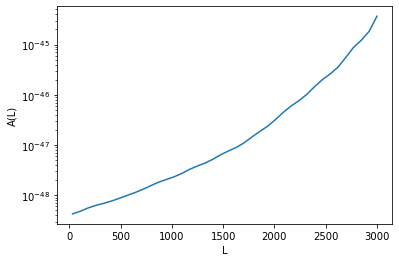

In [6]:
plt.semilogy(Lv,AL)
plt.ylabel('A(L)')
plt.xlabel('L')
plt.show()

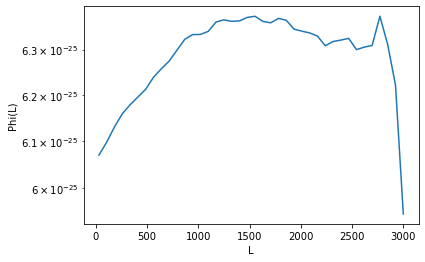

In [7]:
plt.semilogy(Lv,Phi)
plt.ylabel('Phi(L)')
plt.xlabel('L')
plt.show()

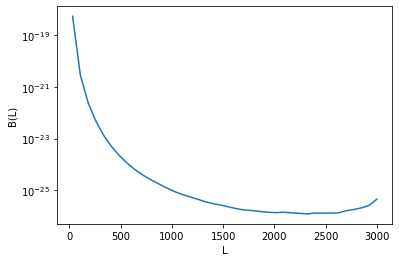

In [21]:
plt.semilogy(Lv,BL)
plt.ylabel('B(L)')
plt.xlabel('L')
plt.show()

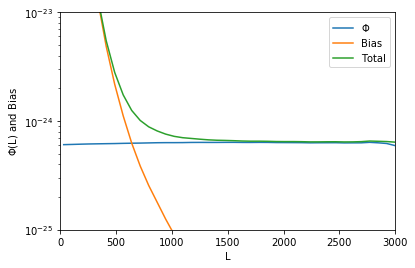

In [9]:
plt.semilogy(Lv,Phi, label = '$\Phi$')
plt.semilogy(Lv,BL, label = 'Bias')
plt.semilogy(Lv,Phi+BL, label = 'Total')
plt.xlim(0,3000)
plt.ylim(1e-25, 1e-23)
plt.ylabel('$\Phi$(L) and Bias')
plt.xlabel('L')
plt.legend()
plt.show()

In [84]:
np.sum((dPsi_dCphi*cphiphi[ellv.astype(int)]).T*1./Phi*(ellv[1]-ellv[0]), axis = 0)
np.savetxt('dPsi_dCphi.txt', dPsi_dCphi)
np.savetxt('dlogPsi_dlogCphi.txt', (dPsi_dCphi*cphiphi[ellv.astype(int)]).T*1./Phi)


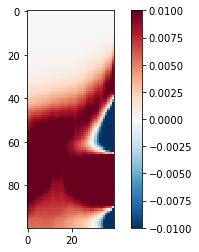

In [81]:
plt.imshow((dPsi_dCphi*cphiphi[ellv.astype(int)]).T*1./Phi*(ellv[1]-ellv[0]), vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')
plt.colorbar()

In [10]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

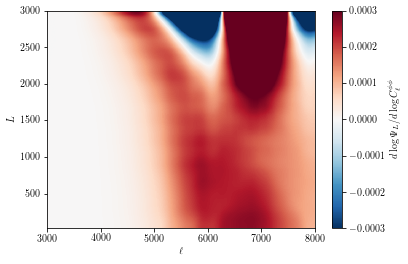

In [12]:
#dlogPsi_dlogCphi = np.loadtxt('dlogPsi_dlogCphi.txt')

nL = 40
Lmax = 3000
Lmin = 30
Lv = np.linspace(Lmin, Lmax, nL)

nell = 100
ellmax = 8000
ellmin = 3000
ellv = np.linspace(ellmin, ellmax, nell)

plt.imshow(dlogPsi_dlogCphi.T, vmin = -0.0003, vmax = 0.0003, extent = (ellmin, ellmax, Lmin, Lmax),
           cmap = 'RdBu_r', aspect = 'auto', interpolation = 'gaussian', origin = 'lower')
plt.xlabel('$\ell$')
plt.ylabel('$L$')
plt.colorbar(label = '$d\log \Psi_L / d\log C_\ell^{\phi\phi}$')
plt.savefig('dlogPsi_dlogCphi.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
%%time

## Amplitude of A(L) seems to depend on choice of sampling here
## Increase for better precision at cost of speed and memory usage
nl1x, nl1y = (200, 200)
l1max = 7000
l1min = 6000
l1x = np.linspace(-l1max, l1max, nl1x)
l1y = np.linspace(-l1max, l1max, nl1y)
l1xv, l1yv = np.meshgrid(l1x, l1y, sparse=True)  # make sparse output arrays

## Turnover of Phi(L) seems to depend on choice of sampling here
## Increase for better precision at cost of speed and memory usage
nl2x, nl2y = (40, 40)
l2max = 3000
l2min = 30
l2x = np.linspace(-l2max, l2max, nl2x)
l2y = np.linspace(-l2max, l2max, nl2y)
l2xv, l2yv = np.meshgrid(l2x, l2y, sparse=True)  # make sparse output arrays

nL = 40
Lmax = 3000
Lmin = 30
Lv = np.linspace(Lmin, Lmax, nL)

nell = 200
ellmax = 10000
ellmin = 3000
ellv = np.linspace(ellmin, ellmax, nell)


## Do each L individually to save on memory usage
## Loop is a bit slower than vectorized calculation, but memory savings is factor of nL

AL = np.zeros(np.shape(Lv)[0])
Phi = np.zeros(np.shape(Lv)[0])
BL = np.zeros(np.shape(Lv)[0])
dPsi_dCphi = np.zeros((np.shape(Lv)[0],np.shape(ellv)[0]))


for iL, LL in enumerate(Lv):
    AL[iL] = 1./l1integral(l1xv, l1yv, [LL], l2xv, l2yv, 
                           ctt_unlensed, ctt_total_CMBS4, Clphiphi = None, 
                           l1min = l1min, l1max = l1max, l2min = l2min, l2max = l2max)
    Phi[iL] = l1integral(l1xv, l1yv, [LL], l2xv, l2yv, 
                         ctt_unlensed, ctt_total_CMBS4, Clphiphi = cphiphi, 
                         l1min = l1min, l1max = l1max, l2min = l2min, l2max = l2max)*AL[iL]
#     BL[iL] = bias_integral(l1xv, l1yv, [LL], ctt_unlensed, ctt_total_CMBS4, g_or_h = 'g', l1min = l1min, l1max = l1max) \
#             * bias_integral(l2xv, l2yv, [-LL], ctt_unlensed, ctt_total_CMBS4, g_or_h = 'h', l1min = l2min, l1max = l2max) \
#             * AL[iL] * cphiphi[np.rint(LL).astype(int)]
#             # Need -L in one of bias integrals to form C_L^{phiphi}
    for iell, ell in enumerate(ellv):
        dPsi_dCphi[iL,iell] = l1integral(l1xv, l1yv, [LL], l2xv, l2yv,
                             ctt_unlensed, ctt_total_CMBS4, Clphiphi = None, 
                             l1min = l1min, l1max = l1max, l2min = l2min, l2max = l2max,
                             ell = ell, dPsi_dCphi = True)*AL[iL]

/users/jrmeyers/.conda/envs/idp_cobaya/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
dlogPsi_dlogCphi = (dPsi_dCphi*cphiphi[ellv.astype(int)]).T*1./Phi
print(np.sum((dPsi_dCphi*cphiphi[ellv.astype(int)]).T*1./Phi*(ellv[1]-ellv[0]), axis = 0))
np.savetxt('dPsi_dCphi_6000_7000.txt', dPsi_dCphi)
np.savetxt('dlogPsi_dlogCphi_6000_7000.txt', (dPsi_dCphi*cphiphi[ellv.astype(int)]).T*1./Phi)


In [ ]:
#dlogPsi_dlogCphi = np.loadtxt('dlogPsi_dlogCphi.txt')

nL = 40
Lmax = 3000
Lmin = 30
Lv = np.linspace(Lmin, Lmax, nL)

nell = 100
ellmax = 10000
ellmin = 3000
ellv = np.linspace(ellmin, ellmax, nell)

plt.imshow(dlogPsi_dlogCphi.T, vmin = -0.0006, vmax = 0.0006, extent = (ellmin, ellmax, Lmin, Lmax),
           cmap = 'RdBu_r', aspect = 'auto', interpolation = 'gaussian', origin = 'lower')
plt.xlabel('$\ell$')
plt.ylabel('$L$')
plt.colorbar(label = '$d\log \Psi_L / d\log C_\ell^{\phi\phi}$')
plt.savefig('dlogPsi_dlogCphi_6000_7000.pdf', bbox_inches = 'tight')
plt.show()

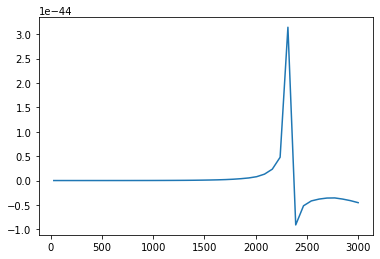

In [15]:
plt.plot(Lv, AL)

In [ ]:
def N1_bias_integral_Kesden(l1xv, l1yv, Lv, l2xv, l2yv, ClTTunlensed, ClTTtotal, Clphiphi = None, l1min = 30, l1max = 8000, l2min = 30, l2max = 8000):
    
    #Add axes in order to vectorize integral
    l1x = np.expand_dims(np.expand_dims(np.expand_dims(l1xv,axis=0),axis=-1),axis=-1)
    l1y = np.expand_dims(np.expand_dims(np.expand_dims(l1yv,axis=0),axis=-1),axis=-1)
    L = np.expand_dims(np.expand_dims(np.expand_dims(np.expand_dims(Lv,axis=-1),axis=-1),axis=-1),axis=-1)
    
    ## Testing:
    #print(np.shape(l1x))
    #print(np.shape(l1y))
    #print(np.shape(L))
    
    Ldotl2 = l2xv*L
    LdotLminusl2 = L*(L-l2xv)
    Ldotl1 = l1x*L
    LdotLminusl1 = L*(L-l1x)

    
    l2dotl2minusl1 = l2xv*(l2xv-l1x)+l2yv*(l2yv-l1y)
    Lminusl2dotl1minusl2 = (L-l2xv)*(l1x-l2xv) + (-l2yv)*(l1y-l2yv)
    Lminusl1dotl1minusl2 = (L-l1x)*(l1x-l2xv) + (-l1y)*(l1y-l2yv)
    Lminusl1minusl2dotl1 = (L-l1x-l2xv)*l1x + (-l1y-l2yv)*l1y
    Lminusl1minusl2dotLminusl2 = (L-l1x-l2xv)*(L-l2xv) + (-l1y-l2yv)*(-l2yv)
    l1minusLplusl2dotLminusl1 = (l1x-L+l2xv)*(L-l1x) + (l1y+l2yv)*(-l1y)
    l1minusLplusl2dotl2 = (l1x-L+l2xv)*l2xv + (l1y+l2yv)*l2yv
    #l2dotl2minusL = l2xv*(l2xv-L)+l2yv*l2yv
    modl2 = np.sqrt(l2xv**2+l2yv**2)
    modLminusl2 = np.sqrt((L-l2xv)**2 + l2yv**2)
    modl1minusl2 = np.sqrt((l1x-l2xv)**2 + (l1y-l2yv)**2)
    
    maskl2 = np.ones(np.shape(modl2),dtype = int)
    maskl2[np.where(modl2 < l2min)] = 0
    maskl2[np.where(modl2 > l2max)] = 0

    maskLminusl2 = np.ones(np.shape(modLminusl2),dtype = int)
    maskLminusl2[np.where(modLminusl2 < l2min)] = 0
    maskLminusl2[np.where(modLminusl2 > l2max)] = 0
    
    l1dotl1minusL = l1xv*(l1xv-L)+l1yv*l1yv
    l1dotl2minusl1 = l1x*(l2xv-l1x)+l1y*(l2yv-l1y)
    modl1 = np.sqrt(l1x**2+l1y**2)
    modLminusl1 = np.sqrt((L-l1x)**2 + l1y**2)
    
    maskl1 = np.ones(np.shape(modl1),dtype = int)
    maskl1[np.where(modl1 < l1min)] = 0
    maskl1[np.where(modl1 > l1max)] = 0

    maskLminusl1 = np.ones(np.shape(modLminusl1),dtype = int)
    maskLminusl1[np.where(modLminusl1 < l1min)] = 0
    maskLminusl1[np.where(modLminusl1 > l1max)] = 0
    
    modl1minusLplusl2 = np.sqrt((l1x-L+l2xv)**2 + (l1y+l2yv)**2)
    
    # F(l1,L-l1) * F(l2,L-L2) * [C^phi(l1-l2) * f(-l1,l2) * f(l1-L,L-l2) + C^phi(l1-L+l2) * f(-l1,L-l2) * f(l1-L,l2)]
    #maskl1 * maskLminusl1 * maskl2 * maskLminusl2 \
    integrand = 1. \
        * ( Ldotl1*ClTTunlensed[np.rint(modl1).astype(int)] + LdotLminusl1*ClTTunlensed[np.rint(modLminusl1).astype(int)] ) \
        * 1./(2. * ClTTtotal[np.rint(modl1).astype(int)] * ClTTtotal[np.rint(modLminusl1).astype(int)]) \
        * ( Ldotl2*ClTTunlensed[np.rint(modl2).astype(int)] + LdotLminusl2*ClTTunlensed[np.rint(modLminusl2).astype(int)] ) \
        * 1./(2. * ClTTtotal[np.rint(modl2).astype(int)] * ClTTtotal[np.rint(modLminusl2).astype(int)]) \
        * ( Clphiphi[np.rint(modl1minusl2).astype(int)] \
        * ( -l1dotl2minusl1*ClTTunlensed[np.rint(modl1).astype(int)] + l2dotl2minusl1*ClTTunlensed[np.rint(modl2).astype(int)] ) \
        * ( -Lminusl1dotl1minusl2*ClTTunlensed[np.rint(modLminusl1).astype(int)] + Lminusl2dotl1minusl2*ClTTunlensed[np.rint(modLminusl2).astype(int)] ) \
        + Clphiphi[np.rint(modl1minusLplusl2).astype(int)] \
        * ( -Lminusl1minusl2dotl1*ClTTunlensed[np.rint(modl1).astype(int)] + Lminusl1minusl2dotLminusl2*ClTTunlensed[np.rint(modLminusl2).astype(int)] ) \
        * ( -l1minusLplusl2dotLminusl1*ClTTunlensed[np.rint(modLminusl1).astype(int)] + l1minusLplusl2dotl2*ClTTunlensed[np.rint(modl2).astype(int)] ) )
    
    #print(integrand)
    
    deltal2x = l2xv[0,1]-l2xv[0,0]
    deltal2y = l2yv[1,0]-l2yv[0,0]
    deltal1x = l1xv[0,1]-l1xv[0,0]
    deltal1y = l1yv[1,0]-l1yv[0,0]
    
    integrand*= deltal1x*deltal1y/((2*np.pi)**2) * deltal2x*deltal2y/((2*np.pi)**2)
    
    #integrand = np.nan_to_num(integrand)
    
    #print(integrand)
    
    ## Testing:
    #print(np.shape(integrand))
    
    return np.sum(integrand, axis=(-4,-3,-2,-1))

def N1_bias_integral_Hanson(l1xv, l1yv, Lv, l2xv, l2yv, ClTTunlensed, ClTTtotal, Clphiphi = None, l1min = 30, l1max = 8000, l2min = 30, l2max = 8000):
    
    #Add axes in order to vectorize integral
    l1x = np.expand_dims(np.expand_dims(np.expand_dims(l1xv,axis=0),axis=-1),axis=-1)
    l1y = np.expand_dims(np.expand_dims(np.expand_dims(l1yv,axis=0),axis=-1),axis=-1)
    L = np.expand_dims(np.expand_dims(np.expand_dims(np.expand_dims(Lv,axis=-1),axis=-1),axis=-1),axis=-1)
    
    ## Testing:
    #print(np.shape(l1x))
    #print(np.shape(l1y))
    #print(np.shape(L))
    
    Ldotl2 = l2xv*L
    LdotLminusl2 = L*(L-l2xv)
    Ldotl1 = l1x*L
    LdotLminusl1 = L*(L-l1x)

    
    #l2dotl2minusl1 = l2xv*(l2xv-l1x)+l2yv*(l2yv-l1y)
    #Lminusl2dotl1minusl2 = (L-l2xv)*(l1x-l2xv) + (-l2yv)*(l1y-l2yv)
    #l2dotl2minusL = l2xv*(l2xv-L)+l2yv*l2yv
    modl2 = np.sqrt(l2xv**2+l2yv**2)
    modLminusl2 = np.sqrt((L-l2xv)**2 + l2yv**2)
    modl1minusl2 = np.sqrt((l1x-l2xv)**2 + (l1y-l2yv)**2)
    
    maskl2 = np.ones(np.shape(modl2),dtype = int)
    maskl2[np.where(modl2 < l2min)] = 0
    maskl2[np.where(modl2 > l2max)] = 0

    maskLminusl2 = np.ones(np.shape(modLminusl2),dtype = int)
    maskLminusl2[np.where(modLminusl2 < l2min)] = 0
    maskLminusl2[np.where(modLminusl2 > l2max)] = 0
    
    #l1dotl1minusL = l1xv*(l1xv-L)+l1yv*l1yv
    modl1 = np.sqrt(l1x**2+l1y**2)
    modLminusl1 = np.sqrt((L-l1x)**2 + l1y**2)
    
    maskl1 = np.ones(np.shape(modl1),dtype = int)
    maskl1[np.where(modl1 < l1min)] = 0
    maskl1[np.where(modl1 > l1max)] = 0

    maskLminusl1 = np.ones(np.shape(modLminusl1),dtype = int)
    maskLminusl1[np.where(modLminusl1 < l1min)] = 0
    maskLminusl1[np.where(modLminusl1 > l1max)] = 0
    
    modl1minusLplusl2 = np.sqrt((l1x-L+l2xv)**2 + (l1y+l2yv)**2)
    l1dotl1minusl2 = l1x*(l1x-l2xv)+l1y*(l1y-l2yv)
    Lminusl1dotl1minusl2 = (L-l1x)*(l1x-l2xv) + (-l1y)*(l1y-l2yv)
    l1dotl1minusLplusl2 = l1x*(l1x-L+l2xv) + l1y*(l1y+l2yv)
    l2dotl1minusLplusl2 = l2xv*(l1x-L+l2xv) + l2yv*(l1y+l2yv)
    
    # F(l1,L-l1) * F(l2,L-L2) * [C^phi(l1-l2) * C^T(l1) * C^T(L-l1) * l1.(l1-l2) * (L-l1).(l1-l2) + C^phi(l1-L+l2) * C^T(l1) * C^T(l2) * l1.(l1-L+l2) * (-l2).(l1-L+l2)]
    #maskl1 * maskLminusl1 * maskl2 * maskLminusl2 \
    integrand = -4. * maskl1 * maskLminusl1 * maskl2 * maskLminusl2 \
        * ( Ldotl1*ClTTunlensed[np.rint(modl1).astype(int)] + LdotLminusl1*ClTTunlensed[np.rint(modLminusl1).astype(int)] ) \
        * 1./(2. * ClTTtotal[np.rint(modl1).astype(int)] * ClTTtotal[np.rint(modLminusl1).astype(int)]) \
        * ( Ldotl2*ClTTunlensed[np.rint(modl2).astype(int)] + LdotLminusl2*ClTTunlensed[np.rint(modLminusl2).astype(int)] ) \
        * 1./(2. * ClTTtotal[np.rint(modl2).astype(int)] * ClTTtotal[np.rint(modLminusl2).astype(int)]) \
        * ( Clphiphi[np.rint(modl1minusl2).astype(int)] * ClTTunlensed[np.rint(modl1).astype(int)] * ClTTunlensed[np.rint(modLminusl1).astype(int)] \
        * l1dotl1minusl2 * Lminusl1dotl1minusl2
        + Clphiphi[np.rint(modl1minusLplusl2).astype(int)] * ClTTunlensed[np.rint(modl1).astype(int)] * ClTTunlensed[np.rint(modl2).astype(int)] \
        * l1dotl1minusLplusl2 * l2dotl1minusLplusl2 * (-1.) )
    
    #print(integrand)
    
    deltal2x = l2xv[0,1]-l2xv[0,0]
    deltal2y = l2yv[1,0]-l2yv[0,0]
    deltal1x = l1xv[0,1]-l1xv[0,0]
    deltal1y = l1yv[1,0]-l1yv[0,0]
    
    integrand*= deltal1x*deltal1y/((2*np.pi)**2) * deltal2x*deltal2y/((2*np.pi)**2)
    
    #integrand = np.nan_to_num(integrand)
    
    #print(integrand)
    
    ## Testing:
    #print(np.shape(integrand))
    
    return np.sum(integrand, axis=(-4,-3,-2,-1))

In [5]:
%load_ext cython

In [6]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

cimport cython
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def N1_bias_integral_cy_Hanson(int L, double[:] ClTTunlensed, double[:] ClTTtotal, double[:] Clphiphi, int lmin, int lmax, int dl):
    
    cdef int l1x
    cdef int l1y
    cdef int l2x
    cdef int l2y
    cdef int nL
    cdef int lmax_round
    nL = lmax/dl
    lmax_round = nL*dl
    print(lmax_round)
    
    cdef int Ldotl2
    cdef int LdotLminusl2
    cdef int Ldotl1
    cdef int LdotLminusl1
    
    cdef int l1dotl1minusl2
    cdef int Lminusl1dotl1minusl2
    cdef int l1dotl1minusLplusl2
    cdef int l2dotl1minusLplusl2
    
    cdef int modl1
    cdef int modLminusl1
    cdef int modl2
    cdef int modLminusl2
    cdef int modl1minusl2
    cdef int modl1minusLplusl2
    
    cdef double integral = 0
    
    #for l1x from -lmax <= l1x < lmax by dl:
    for l1x in prange(-lmax_round, lmax_round, dl, nogil = True):
        Ldotl1 = l1x*L
        LdotLminusl1 = L*(L-l1x)
        for l1y from -lmax_round <= l1y < lmax_round by dl:
            modl1 = <int> ((l1x*l1x+l1y*l1y)**(0.5))
            modLminusl1 = <int> (((L-l1x)*(L-l1x) + l1y*l1y)**(0.5))
            for l2x from -lmax_round <= l2x < lmax_round by dl:
                Ldotl2 = l2x*L
                LdotLminusl2 = L*(L-l2x)
                for l2y from -lmax_round <= l2y < lmax_round by dl:
                    modl2 = <int> ((l2x*l2x+l2y*l2y)**(0.5))
                    modLminusl2 = <int> (((L-l2x)*(L-l2x) + l2y*l2y)**(0.5))
                    modl1minusLplusl2 = <int> (((l1x-L+l2x)*(l1x-L+l2x) + (l1y+l2y)*(l1y+l2y))**(0.5))
                    modl1minusl2 = <int> (((l1x-l2x)*(l1x-l2x) + (l1y-l2y)*(l1y-l2y))**(0.5))
                    l1dotl1minusl2 = l1x*(l1x-l2x)+l1y*(l1y-l2y)
                    Lminusl1dotl1minusl2 = (L-l1x)*(l1x-l2x) + (-l1y)*(l1y-l2y)
                    l1dotl1minusLplusl2 = l1x*(l1x-L+l2x) + l1y*(l1y+l2y)
                    l2dotl1minusLplusl2 = l2x*(l1x-L+l2x) + l2y*(l1y+l2y)
                    
                    if (modl1 < lmin or modl1 > lmax):
                        integral += 0.
                    elif (modl2 < lmin or modl2 > lmax):
                        integral += 0.
                    elif (modLminusl1 < lmin or modLminusl1 > lmax):
                        integral += 0.
                    elif (modLminusl2 < lmin or modLminusl2 > lmax):
                        integral += 0.
                    else:
                        integral += -4.  \
                            * ( Ldotl1*ClTTunlensed[modl1] + LdotLminusl1*ClTTunlensed[modLminusl1] ) \
                            * 1./(2. * ClTTtotal[modl1] * ClTTtotal[modLminusl1]) \
                            * ( Ldotl2*ClTTunlensed[modl2] + LdotLminusl2*ClTTunlensed[modLminusl2] ) \
                            * 1./(2. * ClTTtotal[modl2] * ClTTtotal[modLminusl2]) \
                            * ( Clphiphi[modl1minusl2] * ClTTunlensed[modl1] * ClTTunlensed[modLminusl1] \
                            * l1dotl1minusl2 * Lminusl1dotl1minusl2
                            + Clphiphi[modl1minusLplusl2] * ClTTunlensed[modl1] * ClTTunlensed[modl2] \
                            * l1dotl1minusLplusl2 * l2dotl1minusLplusl2 * (-1.) )
    
    integral *= dl*dl*dl*dl
    
    return integral
                    


In [7]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

cimport cython
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def N1_bias_integral_cy_Kesden(int LL, double[:] ClTTunlensed, double[:] ClTTtotal, double[:] Clphiphi, int lmin, int lmax, int dl):
    
    cdef int l1x
    cdef int l1y
    cdef int l2x
    cdef int l2y
    cdef int L = LL
    
    cdef int Ldotl2
    cdef int LdotLminusl2
    cdef int Ldotl1
    cdef int LdotLminusl1
    
#     cdef int l1dotl1minusl2
#     cdef int Lminusl1dotl1minusl2
#     cdef int l1dotl1minusLplusl2
#     cdef int l2dotl1minusLplusl2

    cdef int l1dotl2minusl1
    cdef int l2dotl2minusl1
    cdef int Lminusl1dotl1minusl2
    cdef int Lminusl2dotl1minusl2
    cdef int Lminusl1minusl2dotl1
    cdef int Lminusl1minusl2dotLminusl2
    cdef int l1minusLplusl2dotLminusl1
    cdef int l1minusLplusl2dotl2
    
    cdef int modl1
    cdef int modLminusl1
    cdef int modl2
    cdef int modLminusl2
    cdef int modl1minusl2
    cdef int modl1minusLplusl2
    
    cdef double integral = 0
    
    #for l1x from -lmax <= l1x < lmax by dl:
    for l1x in prange(-lmax, lmax, dl, nogil = True):
        Ldotl1 = l1x*L
        LdotLminusl1 = L*(L-l1x)
        for l1y from -lmax <= l1y < lmax by dl:
            modl1 = <int> ((l1x*l1x+l1y*l1y)**(0.5))
            modLminusl1 = <int> (((L-l1x)*(L-l1x) + l1y*l1y)**(0.5))
            for l2x from -lmax <= l2x < lmax by dl:
                Ldotl2 = l2x*L
                LdotLminusl2 = L*(L-l2x)
                for l2y from -lmax <= l2y < lmax by dl:
                    modl2 = <int> ((l2x*l2x+l2y*l2y)**(0.5))
                    modLminusl2 = <int> (((L-l2x)*(L-l2x) + l2y*l2y)**(0.5))
                    modl1minusLplusl2 = <int> (((l1x-L+l2x)*(l1x-L+l2x) + (l1y+l2y)*(l1y+l2y))**(0.5))
                    modl1minusl2 = <int> (((l1x-l2x)*(l1x-l2x) + (l1y-l2y)*(l1y-l2y))**(0.5))
                    #l1dotl1minusl2 = l1x*(l1x-l2x)+l1y*(l1y-l2y)
                    #Lminusl1dotl1minusl2 = (L-l1x)*(l1x-l2x) + (-l1y)*(l1y-l2y)
                    #l1dotl1minusLplusl2 = l1x*(l1x-L+l2x) + l1y*(l1y+l2y)
                    #l2dotl1minusLplusl2 = l2x*(l1x-L+l2x) + l2y*(l1y+l2y)
                    
                    l1dotl2minusl1 = l1x*(l1x-l2x)+l1y*(l1y-l2y)
                    l2dotl2minusl1 = l2x*(l2x-l1x)+l2y*(l2y-l1y)
                    Lminusl1dotl1minusl2 = (L-l1x)*(l1x-l2x) + (-l1y)*(l1y-l2y)
                    Lminusl2dotl1minusl2 = (L-l2x)*(l1x-l2x) + (-l2y)*(l1y-l2y)
                    Lminusl1minusl2dotl1 = (L-l1x-l2x)*l1x + (-l1y-l2y)*l1y
                    Lminusl1minusl2dotLminusl2 = (L-l1x-l2x)*(L-l2x) + (-l1y-l2y)*(-l2y)
                    l1minusLplusl2dotLminusl1 = (l1x-L+l2x)*(L-l1x) + (l1y+l2y)*(-l1y)
                    l1minusLplusl2dotl2 = (l1x-L+l2x)*l2x + (l1y+l2y)*l2y
                    
                    if (modl1 < lmin or modl1 > lmax):
                        integral += 0.
                    elif (modl2 < lmin or modl2 > lmax):
                        integral += 0.
                    elif (modLminusl1 < lmin or modLminusl1 > lmax):
                        integral += 0.
                    elif (modLminusl2 < lmin or modLminusl2 > lmax):
                        integral += 0.
                    else:
                        integral += 1. \
                            * ( Ldotl1*ClTTunlensed[modl1] + LdotLminusl1*ClTTunlensed[modLminusl1] ) \
                            * 1./(2. * ClTTtotal[modl1] * ClTTtotal[modLminusl1]) \
                            * ( Ldotl2*ClTTunlensed[modl2] + LdotLminusl2*ClTTunlensed[modLminusl2] ) \
                            * 1./(2. * ClTTtotal[modl2] * ClTTtotal[modLminusl2]) \
                            * ( Clphiphi[modl1minusl2] \
                            * ( -l1dotl2minusl1*ClTTunlensed[modl1] + l2dotl2minusl1*ClTTunlensed[modl2] ) \
                            * ( -Lminusl1dotl1minusl2*ClTTunlensed[modLminusl1] + Lminusl2dotl1minusl2*ClTTunlensed[modLminusl2] ) \
                            + Clphiphi[modl1minusLplusl2] \
                            * ( -Lminusl1minusl2dotl1*ClTTunlensed[modl1] + Lminusl1minusl2dotLminusl2*ClTTunlensed[modLminusl2] ) \
                            * ( -l1minusLplusl2dotLminusl1*ClTTunlensed[modLminusl1] + l1minusLplusl2dotl2*ClTTunlensed[modl2] ) )
    
    integral *= dl*dl*dl*dl
    
    return integral
                    


In [32]:
%%time

N1_bias_integral_cy_Hanson(50, ctt_unlensed, ctt_total_planck, cphiphi, 30, 3000, 50)/((2.*np.pi)**4)

3000
CPU times: user 1min, sys: 140 ms, total: 1min
Wall time: 3.99 s


53963920529.466576

In [33]:
%%time

2*N1_bias_integral_cy_Kesden(50, ctt_unlensed, ctt_total_planck, cphiphi, 30, 3000, 50)/((2.*np.pi)**4)

CPU times: user 1min 1s, sys: 194 ms, total: 1min 1s
Wall time: 4.07 s


53963920529.149445

In [10]:
nl1x, nl1y = (200, 200)
l1max = 3000
l1min = 20
l1x = np.linspace(-l1max, l1max, nl1x)
l1y = np.linspace(-l1max, l1max, nl1y)
l1xv, l1yv = np.meshgrid(l1x, l1y, sparse=True)  # make sparse output arrays

nL = 64
Lmax = 3000
Lmin = 30
Lv = np.linspace(Lmin, Lmax, nL)

pbar = tqdm(total=len(Lv))

N0_bias = np.zeros(np.shape(Lv)[0])

for iL, LL in enumerate(Lv):
    N0_bias[iL] = 1./N0_bias_integral(l1xv, l1yv, [LL], ctt_unlensed, ctt_total_planck, l1min = l1min, l1max = l1max)
    pbar.update(1)
    
pbar.close()

100%|██████████| 64/64 [00:00<00:00, 299.40it/s]


In [14]:
%%time

nl1x, nl1y = (200, 200)
l1max = 5000
l1min = 30
l1x = np.linspace(-l1max, l1max, nl1x)
l1y = np.linspace(-l1max, l1max, nl1y)
l1xv, l1yv = np.meshgrid(l1x, l1y, sparse=True)  # make sparse output arrays

dL = 50
Lmax = 3000
Lmin = 30
LV = np.arange(Lmin, Lmax, 50)
#Lv = np.linspace(Lmin, Lmax, nL)
#Lv = np.geomspace(Lmin, Lmax, nL)

N0_bias = np.zeros(np.shape(Lv)[0])
N1_bias_Hanson = np.zeros(np.shape(Lv)[0])
N1_bias_Kesden = np.zeros(np.shape(Lv)[0])

pbar = tqdm(total=len(Lv))

for iL, LL in enumerate(Lv):
    N0_bias[iL] = 1./N0_bias_integral(l1xv, l1yv, [LL], ctt_unlensed, ctt_total_planck, l1min = l1min, l1max = l1max)
    #N1_bias_Hanson[iL] = N1_bias_integral_cy_Hanson(L = LL, ClTTunlensed=ctt_unlensed, ClTTtotal=ctt_total_planck, Clphiphi=cphiphi, lmin=l1min, lmax=l1max, dl=50)
    N1_bias_Hanson[iL] = N1_bias_integral_cy_Hanson(LL, ctt_unlensed, ctt_total_planck, cphiphi, l1min, l1max, 100)
    #pbar.update(1)
    #N1_bias_Kesden[iL] = N1_bias_integral_cy_Kesden(L = LL, ClTTunlensed=ctt_unlensed, ClTTtotal=ctt_total_planck, Clphiphi=cphiphi, lmin=l1min, lmax=l1max, dl=50)
    #N1_bias_Kesden[iL] = N1_bias_integral_cy_Kesden(LL, ctt_unlensed, ctt_total_planck, cphiphi, l1min, l1max, 100)
    pbar.update(1)

pbar.close()

N1_bias_Hanson *= N0_bias*N0_bias/((2.*np.pi)**4)
#N1_bias_Kesden *= N0_bias*N0_bias/((2.*np.pi)**4)
    

100%|██████████| 64/64 [02:04<00:00,  1.95s/it]

CPU times: user 32min 21s, sys: 12.1 s, total: 32min 33s
Wall time: 2min 4s


In [17]:
N1_bias_Hanson

array([-5.97203002e-13, -2.36549101e-14, -3.68695738e-15, -8.66860298e-16,
       -9.03749460e-16, -1.57633972e-16, -5.16504394e-16, -4.32706385e-17,
       -3.84727645e-16, -1.43923910e-17,  4.96063467e-19, -6.67541076e-18,
       -1.25714429e-16, -3.85431712e-18, -2.72773879e-17, -2.48631038e-18,
       -7.41369697e-18, -1.90120641e-18, -2.65673319e-18, -1.68496209e-18,
       -1.08092191e-18, -1.50911441e-18, -4.89256627e-19, -1.57208963e-18,
       -2.19665897e-19, -2.01369910e-18, -9.59721646e-20, -4.52944697e-18,
       -3.12421570e-20, -6.72436871e-19,  1.54606410e-20,  2.77187950e-19,
        5.94283230e-20,  2.95254518e-19,  1.14653635e-19,  2.59586636e-19,
        1.87211402e-19,  1.97783587e-19,  3.13692115e-19,  1.54270724e-19,
        5.61969382e-19,  1.25344332e-19,  1.03030940e-18,  1.10737425e-19,
        3.17035907e-18,  1.02730070e-19,  6.05794186e-18,  1.04752230e-19,
        1.25260653e-18,  1.14792345e-19,  6.00636248e-19,  1.38731723e-19,
        3.22155506e-19,  

In [26]:
%%time

nl1x, nl1y = (200, 200)
l1max = 10000
l1min = 30
l1x = np.linspace(-l1max, l1max, nl1x)
l1y = np.linspace(-l1max, l1max, nl1y)
l1xv, l1yv = np.meshgrid(l1x, l1y, sparse=True)  # make sparse output arrays

nL = 128
Lmax = 10000
Lmin = 30
Lv = np.linspace(Lmin, Lmax, nL)
#Lv = np.geomspace(Lmin, Lmax, nL)

N0_bias_CMBS4 = np.zeros(np.shape(Lv)[0])
N1_bias_Kesden_CMBS4 = np.zeros(np.shape(Lv)[0])

pbar = tqdm(total=len(Lv))

for iL, LL in enumerate(Lv):
    N0_bias_CMBS4[iL] = 1./N0_bias_integral(l1xv, l1yv, [LL], ctt_unlensed, ctt_total_CMBS4, l1min = l1min, l1max = l1max)
    N1_bias_Kesden_CMBS4[iL] = N1_bias_integral_cy_Kesden(L = LL, ClTTunlensed=ctt_unlensed, ClTTtotal=ctt_total_CMBS4, Clphiphi=cphiphi, lmin=l1min, lmax=l1max, dl=80)
    pbar.update(1)

pbar.close()

N1_bias_Kesden_CMBS4 *= N0_bias_CMBS4*N0_bias_CMBS4/((2.*np.pi)**4)
    


100%|██████████| 128/128 [1:24:38<00:00, 39.68s/it]

CPU times: user 1d 15h 9min 47s, sys: 1min 17s, total: 1d 15h 11min 5s
Wall time: 1h 24min 38s


In [15]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

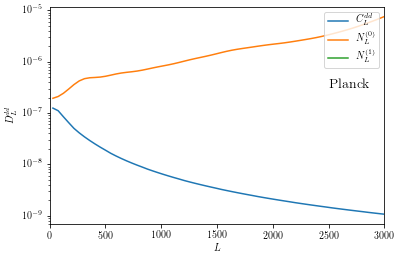

In [16]:
nL = 64
Lmax = 3000
Lmin = 30
Lv_planck = np.linspace(Lmin, Lmax, nL)
#Lv = np.geomspace(Lmin, Lmax, nL)

plt.semilogy(Lv_planck,Lv_planck**4*cphiphi[np.rint(Lv_planck).astype(int)]/(2.*np.pi), label = '$C_L^{dd}$')
plt.semilogy(Lv_planck,Lv_planck**4*N0_bias/(2.*np.pi), label = '$N_L^{(0)}$')
plt.semilogy(Lv_planck,2*Lv_planck**4*N1_bias_Kesden/(2.*np.pi), label = '$N_L^{(1)}$')
plt.text(2500,3e-7, 'Planck', fontsize = 14)
#plt.semilogy(Lv,Lv**4*N1_bias_Hanson/(2.*np.pi))
# plt.semilogy(Lv,-Lv**4*N1_bias_cy_Kesden/(2.*np.pi))
# plt.semilogy(Lv,-Lv**4*N1_bias_cy_Hanson/(2.*np.pi))
plt.ylabel('$D^{dd}_L$')
plt.xlabel('$L$')
plt.xlim(0,3000)
plt.legend(loc = 'upper right')
#plt.savefig('N1_bias_Planck.pdf', bbox_inches = 'tight')
#plt.savefig('N1_bias_Planck.png', bbox_inches = 'tight')
plt.show()


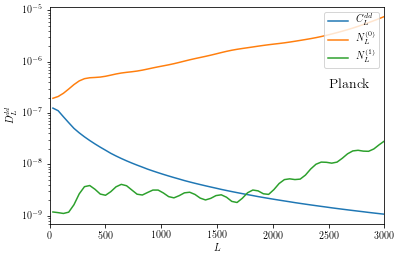

In [47]:
nL = 64
Lmax = 3000
Lmin = 30
Lv_planck = np.linspace(Lmin, Lmax, nL)
#Lv = np.geomspace(Lmin, Lmax, nL)

plt.semilogy(Lv_planck,Lv_planck**4*cphiphi[np.rint(Lv_planck).astype(int)]/(2.*np.pi), label = '$C_L^{dd}$')
plt.semilogy(Lv_planck,Lv_planck**4*N0_bias/(2.*np.pi), label = '$N_L^{(0)}$')
plt.semilogy(Lv_planck,Lv_planck**4*N1_bias_Kesden/(2.*np.pi), label = '$N_L^{(1)}$')
plt.text(2500,3e-7, 'Planck', fontsize = 14)
#plt.semilogy(Lv,Lv**4*N1_bias_Hanson/(2.*np.pi))
# plt.semilogy(Lv,-Lv**4*N1_bias_cy_Kesden/(2.*np.pi))
# plt.semilogy(Lv,-Lv**4*N1_bias_cy_Hanson/(2.*np.pi))
plt.ylabel('$D^{dd}_L$')
plt.xlabel('$L$')
plt.xlim(0,3000)
plt.legend(loc = 'upper right')
plt.savefig('N1_bias_Planck.pdf', bbox_inches = 'tight')
plt.savefig('N1_bias_Planck.png', bbox_inches = 'tight')
plt.show()


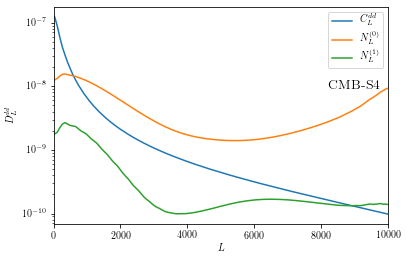

In [49]:
plt.semilogy(Lv,Lv**4*cphiphi[np.rint(Lv).astype(int)]/(2.*np.pi), label = '$C_L^{dd}$')
plt.semilogy(Lv,Lv**4*N0_bias_CMBS4/(2.*np.pi), label = '$N_L^{(0)}$')
plt.semilogy(Lv,Lv**4*N1_bias_Kesden_CMBS4/(2.*np.pi), label = '$N_L^{(1)}$')
plt.text(8200,9e-9, 'CMB-S4', fontsize =14)
#plt.semilogy(Lv,Lv**4*N1_bias_Hanson/(2.*np.pi))
# plt.semilogy(Lv,-Lv**4*N1_bias_cy_Kesden/(2.*np.pi))
# plt.semilogy(Lv,-Lv**4*N1_bias_cy_Hanson/(2.*np.pi))
plt.ylabel('$D^{dd}_L$')
plt.xlabel('$L$')
plt.xlim(0,10000)
plt.legend()
plt.savefig('N1_bias_CMBS4.pdf', bbox_inches = 'tight')
plt.savefig('N1_bias_CMBS4.png', bbox_inches = 'tight')
plt.show()

In [24]:
%%time

nl1x, nl1y = (200, 200)
l1max = 5000
l1min = 30
l1x = np.linspace(-l1max, l1max, nl1x)
l1y = np.linspace(-l1max, l1max, nl1y)
l1xv, l1yv = np.meshgrid(l1x, l1y, sparse=True)  # make sparse output arrays

nL = 64
Lmax = 3000
Lmin = 30
Lv = np.linspace(Lmin, Lmax, nL)

N0_bias = np.zeros(np.shape(Lv)[0])

for iL, LL in enumerate(Lv):
    N0_bias[iL] = 1./N0_bias_integral(l1xv, l1yv, [LL], ctt_unlensed, ctt_total, l1min = l1min, l1max = l1max)

N1_bias_Hanson = np.zeros(np.shape(Lv)[0])

if __name__=='__main__':
    pool = Pool(processes=16)
    N1_bias_Hanson = pool.map(partial(N1_bias_integral_cy_Hanson, ClTTunlensed=ctt_unlensed, ClTTtotal=ctt_total, Clphiphi=cphiphi, lmin=l1min, lmax=l1max, dl=50), Lv)
    pool.close() # ATTENTION HERE

N1_bias_Hanson *= N0_bias*N0_bias/((2.*np.pi)**4)
    


  0%|          | 0/64 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [66]:
N1_bias

array([-9.80379959e-16, -3.40589087e-17, -3.18372531e-17, -2.08676146e-17,
       -3.81496589e-18, -2.40050690e-18, -1.09231410e-17, -2.75792296e-18,
       -8.44770565e-19, -1.03380107e-18, -5.28906820e-18, -6.74982456e-19,
       -4.14206550e-19, -4.90439355e-19, -1.36253673e-19, -2.93854882e-19,
       -1.76063068e-19, -2.05191716e-19, -9.69302668e-19, -1.29463313e-19,
       -7.14100003e-20, -1.52988295e-19, -2.84205520e-19, -4.87005903e-20,
       -4.72683799e-20, -1.08678327e-19, -7.47663067e-20, -3.15548021e-20,
       -2.99576845e-20, -6.39799586e-20, -5.37209633e-20, -2.34015481e-20,
       -1.75125259e-20, -9.62692782e-20, -3.49650340e-20, -2.28395307e-20,
       -3.22109631e-20, -1.15815837e-19, -3.03236553e-20, -1.87125916e-20])

In [ ]:
%%time

nl1x, nl1y = (100, 100)
l1max = 3000
l1min = 30
l1x = np.linspace(-l1max, l1max, nl1x)
l1y = np.linspace(-l1max, l1max, nl1y)
l1xv, l1yv = np.meshgrid(l1x, l1y, sparse=True)  # make sparse output arrays

nL = 20
Lmax = 3000
Lmin = 30
Lv = np.linspace(Lmin, Lmax, nL)

N0_bias = np.zeros(np.shape(Lv)[0])
N1_bias_Kesden = np.zeros(np.shape(Lv)[0])
N1_bias_Hanson = np.zeros(np.shape(Lv)[0])
N1_bias_cy_Kesden = np.zeros(np.shape(Lv)[0])
N1_bias_cy_Hanson = np.zeros(np.shape(Lv)[0])

for iL, LL in enumerate(Lv):
    N0_bias[iL] = 1./N0_bias_integral(l1xv, l1yv, [LL], ctt_unlensed, ctt_total, l1min = l1min, l1max = l1max)
#     N1_bias_Kesden[iL] = N0_bias[iL]*N0_bias[iL] \
#             *N1_bias_integral_Kesden(l1xv, l1yv, [LL], l1xv, l1yv, ctt_unlensed, ctt_total, Clphiphi = cphiphi, l1min = l1min, l1max = l1max, l2min = l1min, l2max = l1max)
#     N1_bias_Hanson[iL] = N0_bias[iL]*N0_bias[iL] \
#             *N1_bias_integral_Hanson(l1xv, l1yv, [LL], l1xv, l1yv, ctt_unlensed, ctt_total, Clphiphi = cphiphi, l1min = l1min, l1max = l1max, l2min = l1min, l2max = l1max)
#     N1_bias_cy_Kesden[iL] = N0_bias[iL]*N0_bias[iL] \
#             *N1_bias_integral_cy_Kesden(LL, ctt_unlensed, ctt_total, cphiphi, l1min, l1max, 50)/((2.*np.pi)**4)
#     N1_bias_cy_Hanson[iL] = N0_bias[iL]*N0_bias[iL] \
#             *N1_bias_integral_cy_Hanson(LL, ctt_unlensed, ctt_total, cphiphi, l1min, l1max, 50)/((2.*np.pi)**4)

In [ ]:
plt.semilogy(Lv,Lv**4*cphiphi[np.rint(Lv).astype(int)]/(2.*np.pi))
plt.semilogy(Lv,Lv**4*N0_bias/(2.*np.pi))
plt.semilogy(Lv,-Lv**4*N1_bias_Kesden/(2.*np.pi))
plt.semilogy(Lv,-Lv**4*N1_bias_Hanson/(2.*np.pi))
plt.semilogy(Lv,-Lv**4*N1_bias_cy_Kesden/(2.*np.pi))
plt.semilogy(Lv,-Lv**4*N1_bias_cy_Hanson/(2.*np.pi))
plt.ylabel('C^{dd}_L')
plt.xlabel('L')
plt.show()